# Hourly Time Series Forecasting using XGBoost

In this notebook we will walk through time series forecasting using XGBoost. The data we will be using is hourly car speed

In [189]:
!pip3 install xgboost

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from sklearn.model_selection import GridSearchCV

In [118]:
!pip install holidays
import holidays
!pip install "holidays==0.10.3"
import holidays
import datetime

# Data

In [119]:
pjme = pd.read_csv('/content/train.csv',index_col=['date'],parse_dates=['date'])

In [120]:
pjme2  = pd.read_csv('/content/test.csv',index_col=['date'],parse_dates=['date'])

In [121]:
pjme = pjme.resample('h').ffill()

In [122]:
pjme

,id,speed
date,,
2017-01-01 00:00:00,0,43.002930
2017-01-01 01:00:00,1,46.118696
2017-01-01 02:00:00,2,44.294158
2017-01-01 03:00:00,3,41.067468
2017-01-01 04:00:00,4,46.448653
...,...,...
2018-12-31 16:00:00,14003,12.501851
2018-12-31 17:00:00,14003,12.501851
2018-12-31 18:00:00,14004,15.979319


In [123]:
pjme.count()

id       17517
speed    17517
dtype: int64

# Train/Test Split

In [124]:
split_date = '01-Dec-2018'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_train = pjme.copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Create Time Series Features

In [125]:
#holidays
hk_holidays = ['2017-01-02', '2017-01-28', '2017-01-30', '2017-01-31', '2017-04-04', '2017-04-14', '2017-04-15', '2017-04-17', '2017-05-03', '2017-05-01', '2017-05-30', '2017-07-01', '2017-10-05', '2017-10-02', '2017-10-28', '2017-12-25', '2017-12-26', '2018-01-01', '2018-02-16', '2018-02-17', '2018-02-19', '2018-04-05', '2018-03-30', '2018-03-31', '2018-04-02', '2018-05-22', '2018-05-01', '2018-06-18', '2018-07-02', '2018-09-25', '2018-10-01', '2018-10-17', '2018-12-25', '2018-12-26', '2019-01-01', '2019-02-05', '2019-02-06', '2019-02-07', '2019-04-05', '2019-04-19', '2019-04-20', '2019-04-22', '2019-05-13', '2019-05-01', '2019-06-07', '2019-07-01', '2019-09-14', '2019-10-01', '2019-10-07', '2019-12-25', '2019-12-26', '2020-01-01', '2020-01-25', '2020-01-27', '2020-01-28', '2020-04-04', '2020-04-10', '2020-04-11', '2020-04-13', '2020-04-30', '2020-05-01', '2020-06-25', '2020-07-01', '2020-10-02', '2020-10-01', '2020-10-26', '2020-12-25', '2020-12-26']

In [130]:
#for date in holidays.HongKong(years=2020).items():
#hk_holidays.append(str(date[0]))

In [128]:
print(hk_holidays)

['2017-01-02', '2017-01-28', '2017-01-30', '2017-01-31', '2017-04-04', '2017-04-14', '2017-04-15', '2017-04-17', '2017-05-03', '2017-05-01', '2017-05-30', '2017-07-01', '2017-10-05', '2017-10-02', '2017-10-28', '2017-12-25', '2017-12-26', '2018-01-01', '2018-02-16', '2018-02-17', '2018-02-19', '2018-04-05', '2018-03-30', '2018-03-31', '2018-04-02', '2018-05-22', '2018-05-01', '2018-06-18', '2018-07-02', '2018-09-25', '2018-10-01', '2018-10-17', '2018-12-25', '2018-12-26', '2019-01-01', '2019-02-05', '2019-02-06', '2019-02-07', '2019-04-05', '2019-04-19', '2019-04-20', '2019-04-22', '2019-05-13', '2019-05-01', '2019-06-07', '2019-07-01', '2019-09-14', '2019-10-01', '2019-10-07', '2019-12-25', '2019-12-26', '2020-01-01', '2020-01-25', '2020-01-27', '2020-01-28', '2020-04-04', '2020-04-10', '2020-04-11', '2020-04-13', '2020-04-30', '2020-05-01', '2020-06-25', '2020-07-01', '2020-10-02', '2020-10-01', '2020-10-26', '2020-12-25', '2020-12-26']


In [134]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['holidays'] = [1 if str(val).split()[0] in hk_holidays else 0 for val in df.index]
    X = df[['hour','dayofweek','quarter','month','year',
            'dayofyear','dayofmonth','weekofyear','holidays']]
    X = df[['hour','dayofweek','year','month','quarter',
            'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [190]:
X_train, y_train = create_features(pjme_train, label='speed')
X_test, y_test = create_features(pjme_test, label='speed')
X_train, y_train = create_features(pjme, label='speed') # using all dataset to train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


# Create XGBoost Model

In [194]:
reg = xgb.XGBRegressor(booster='gbtree',n_estimators=1000,learning_rate =0.300000012)#,max_depth=12
other_params = {'n_estimators':250,'objective':'reg:squarederror'}
reg = xgb.XGBRegressor(**other_params)
reg.fit(X_train, y_train,verbose=False)
#         eval_set=[(X_train, y_train), (X_test, y_test)],
#         early_stopping_rounds=50)
        # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=250,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [166]:
 xgb_model = xgb.XGBRegressor(n_jobs=1)
 clf = GridSearchCV(xgb_model,
                    {'max_depth': [2, 4, 6],
                     'n_estimators': [50, 100, 200]}, verbose=1, n_jobs=1)
 clf.fit(X_train, y_train)
 print(clf.best_score_)
 print(clf.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[13:05:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[13:05:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:05:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:05:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:05:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:05:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:05:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:05:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:06:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   35.8s finished


[13:06:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.7434966393350686
{'max_depth': 4, 'n_estimators': 50}


## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

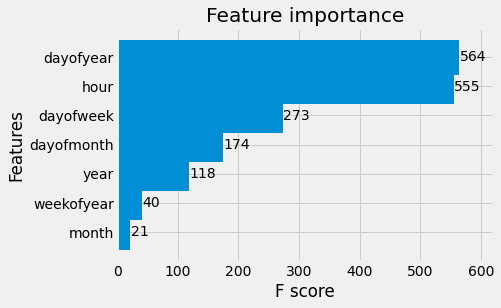

In [167]:
_ = plot_importance(reg, height=1.2)

In [168]:
pjme_all[['Speed_Prediction']]

,Speed_Prediction
date,
2018-12-01 01:00:00,47.666302
2018-12-01 02:00:00,47.957726
2018-12-01 03:00:00,48.233547
2018-12-01 04:00:00,48.233547
2018-12-01 05:00:00,48.238441
...,...
2018-12-31 16:00:00,NaN
2018-12-31 17:00:00,NaN
2018-12-31 18:00:00,NaN


# Error Metrics On Test Set


In [169]:
mean_squared_error(y_true=pjme_test['speed'],
                   y_pred=pjme_test['Speed_Prediction'])

50.619497886464025

In [170]:
mean_absolute_error(y_true=pjme_test['speed'],
                   y_pred=pjme_test['Speed_Prediction'])

4.926407711344584

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [171]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [172]:
mean_absolute_percentage_error(y_true=pjme_test['speed'],
                   y_pred=pjme_test['Speed_Prediction'])

22.939192349733347

# Look at Worst and Best Predicted Days

In [173]:
pjme_test['error'] = pjme_test['speed'] - pjme_test['Speed_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['speed','Speed_Prediction','error','abs_error']]

In [174]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

speed  Speed_Prediction     error  abs_error
year month dayofmonth                                                  
2018 12    2           32.287407         36.439659 -4.152254   6.987143
           9           28.573119         31.760212 -3.187093   9.495697
           1           29.200391         31.986223 -2.785832   5.180160
           3           30.513453         32.648899 -2.135444   3.382757
           12          29.667195         31.635761 -1.968566   3.608459
           6           29.657733         31.550022 -1.892289   4.808261
           24          33.305006         34.980892 -1.675888   3.296684
           17          28.247136         29.886927 -1.639791   5.939999
           22          31.692881         33.229744 -1.536864   6.572568
           4           30.923625         32.283485 -1.359860   3.887690

Notice anything about the over forecasted days? 
- #1 worst day - July 4th, 2016 - is a holiday. 
- #3 worst day - December 25, 2015 - Christmas
- #5 worst day - July 4th, 2016 - is a holiday.   
Looks like our model may benefit from adding a holiday indicator.

In [175]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

speed  Speed_Prediction     error  abs_error
year month dayofmonth                                                  
2018 12    14          33.258545         30.531059  2.727486  12.581253
           9           28.573119         31.760212 -3.187093   9.495697
           8           41.481679         35.055851  6.425828   9.019828
           20          28.421850         28.982841 -0.560990   7.449955
           2           32.287407         36.439659 -4.152254   6.987143
           22          31.692881         33.229744 -1.536864   6.572568
           17          28.247136         29.886927 -1.639791   5.939999
           1           29.200391         31.986223 -2.785832   5.180160
           10          30.569127         31.382740 -0.813613   4.913544
           13          33.392718         30.348072  3.044647   4.902352

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may

In [176]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

speed  Speed_Prediction     error  abs_error
year month dayofmonth                                                  
2018 12    26          35.779637         35.510296  0.269342   3.174561
           31          30.418025         30.089411  0.328613   3.192066
           7           33.024505         31.166910  1.857596   3.274935
           24          33.305006         34.980892 -1.675888   3.296684
           27          32.185121         32.922695 -0.737574   3.302028
           5           33.027604         31.265020  1.762583   3.368335
           3           30.513453         32.648899 -2.135444   3.382757
           29          36.862095         36.973412 -0.111315   3.385414
           30          42.966224         43.826618 -0.860394   3.411177
           12          29.667195         31.635761 -1.968566   3.608459

# Plotting some best/worst predicted days

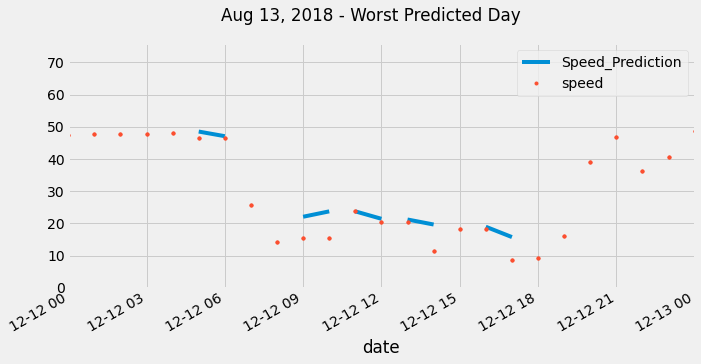

In [177]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['Speed_Prediction','speed']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 76)
ax.set_xbound(lower='12-12-2018', upper='12-13-2018')
plot = plt.suptitle('Aug 13, 2018 - Worst Predicted Day')

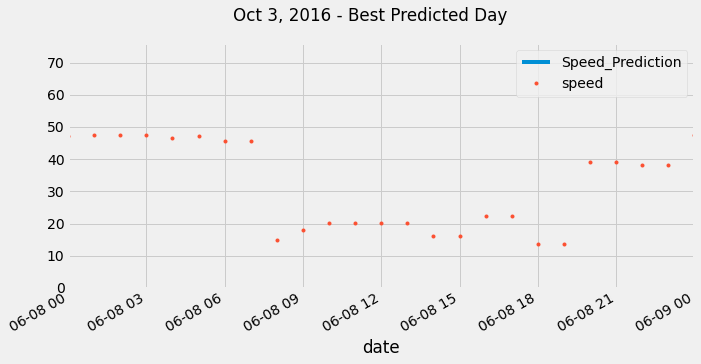

In [178]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['Speed_Prediction','speed']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 76)
ax.set_xbound(lower='06-08-2018', upper='06-09-2018')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

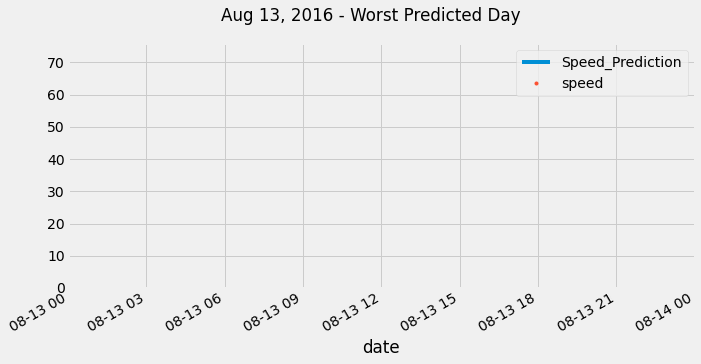

In [179]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['Speed_Prediction','speed']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 76)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')


#Hand in Data

In [180]:
X_handin = create_features(pjme2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


In [181]:
X_handin['Speed_Prediction'] = reg.predict(X_handin)
# X_handin['Speed_Prediction'] =clf.predict(X_handin)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [182]:
X_handin.head(20)

,hour,dayofweek,year,month,quarter,dayofyear,dayofmonth,weekofyear,Speed_Prediction
date,,,,,,,,,
2018-01-01 02:00:00,2,0,2018,1,1,1,1,1,47.830738
2018-01-01 05:00:00,5,0,2018,1,1,1,1,1,48.862957
2018-01-01 07:00:00,7,0,2018,1,1,1,1,1,44.171696
2018-01-01 08:00:00,8,0,2018,1,1,1,1,1,32.773182
2018-01-01 10:00:00,10,0,2018,1,1,1,1,1,34.333302
2018-01-01 16:00:00,16,0,2018,1,1,1,1,1,28.503729
2018-01-01 18:00:00,18,0,2018,1,1,1,1,1,23.366499
2018-02-01 01:00:00,1,3,2018,2,1,32,1,5,47.568302
2018-02-01 02:00:00,2,3,2018,2,1,32,1,5,47.859726


In [183]:
handin_data = X_handin['Speed_Prediction'].reset_index()

In [184]:
#handin_data.reset_index()
handin_data2 = handin_data['Speed_Prediction'].rename('speed')


In [185]:
handin_data2.to_frame()

,speed
0,47.830738
1,48.862957
2,44.171696
3,32.773182
4,34.333302
...,...
3499,14.671143
3500,19.712770
3501,38.465733
3502,36.194523


In [186]:
handin_data2 = handin_data2.reset_index()

In [187]:
handin_data2 = handin_data2.rename(columns={'index': 'id'})

In [188]:
handin_data2

,id,speed
0,0,47.830738
1,1,48.862957
2,2,44.171696
3,3,32.773182
4,4,34.333302
...,...,...
3499,3499,14.671143
3500,3500,19.712770
3501,3501,38.465733
3502,3502,36.194523


In [163]:
handin_data2.to_csv('Submission.csv',index=False)

In [164]:
df = pd.read_csv('./Submission.csv')
df

,id,speed
0,0,47.830738
1,1,48.862957
2,2,44.171696
3,3,32.773182
4,4,34.333300
...,...,...
3499,3499,14.671143
3500,3500,19.712770
3501,3501,38.465733
3502,3502,36.194523


In [68]:
handin_data2

,id,speed
0,0,47.830738
1,1,48.862957
2,2,44.171696
3,3,32.773182
4,4,34.333302
...,...,...
3499,3499,14.671143
3500,3500,19.712770
3501,3501,38.465733
3502,3502,36.194523
